In [1]:
import os
import sys

import numpy as np
import pandas as pd
import polars as pl

import tensorflow as tf

import matplotlib.pyplot as plt
import seaborn as sns

np.set_printoptions(
    edgeitems=30,
    linewidth=100_000,
    #formatter=dict(float=lambda x:"%.3g" % x),
    suppress=True
    )

In [2]:
pattern="""Packing Index: \d*
Rerun: \d
----------------------------------------------------------------------------------------------------
[\s\S]*?
----------------------------------------------------------------------------------------------------"""


In [3]:
root = os.getcwd()
cwd, _ = os.path.split(root)

data_dir = os.path.join(cwd, "raw-data", "repeated_packing_heuristic")

texts = []

for dir_, _, filenames in os.walk(data_dir):
    for filename in filenames:
        filepath = os.path.join(dir_, filename)

        with open(filepath, "r") as file:
            text = file.read()
            
        texts.append(text)

df = pl.DataFrame({"raw": texts})
df = (df
      .with_columns([
          pl.lit(np.arange(len(df))).alias("index"),
          df["raw"].str.extract("dataset_?([ABCX])").alias("dataset"),
          df["raw"].str.extract("dataset_?[ABCX]\s*(\w*)\s").alias("instance"),
          df["raw"].str.extract_all(pattern).alias("logs")
          #df["raw"].str.extract_all("2D Packing Heuristic in Truck P\d*").alias("logs")
        ])
      .drop("raw")
      .explode("logs")
      .filter(
          ~pl.col("logs").str.contains("Heuristische Lösung wird sofort akzeptiert")
      )
      .with_columns([
          pl.col("logs").str.extract("Packing Index: (\d*)").cast(int).alias("packing"),
          pl.col("logs").str.extract("Rerun: (\d*)").cast(int).alias("rerun")
      ])
      .with_columns([
          pl.col("logs").str.extract_all("\[%\] - after (\d+\.\d*) \[s\]").alias("ImprovementTimes"),
          pl.col("logs").str.contains("Optimal Solution confirmed").alias("Solved")
      ])
      .explode("ImprovementTimes")
      .with_columns([
          pl.col("ImprovementTimes").str.extract("(\d+\.\d*)").cast(float)
      ])
      .group_by([
          "index", "dataset", "instance", "logs", "packing", "rerun", "Solved"
      ], maintain_order=True)
      .agg([
          pl.col("ImprovementTimes")
      ])
      .with_columns([
          pl.col("ImprovementTimes").list.len().cast(int).alias("n_Improvements")-1,
          (pl.col("ImprovementTimes").list.len() > 1).alias("Improvement"),
      ])
      .group_by([
          "index", "dataset", "instance", "packing"	
      ], maintain_order=True)
      .agg([
          pl.first("logs"), # Note that everything after the "first" MIP Improvement should not be used
          pl.count("rerun"),
          pl.col("ImprovementTimes"),
          pl.n_unique("n_Improvements").alias("NumberUniqueImprovements"),
          pl.mean("Improvement").alias("ImprovementMean"),
          pl.mean("Solved").alias("SolvedMean"),
      ])
      .with_columns([
          (pl.col("ImprovementMean") * (1-pl.col("ImprovementMean"))).alias("ImprovementVariance"),
          (pl.col("SolvedMean") * (1-pl.col("SolvedMean"))).alias("SolvedVariance"),
          pl.col("logs").str.extract("Time Limit (\d{1,}\.?\d*) \[s\]").cast(float).alias("TimeLimit"),
          pl.col("logs").str.extract_all("Stack \d* with items:").list.len().cast(int).alias("n_stacks"),
          pl.col("logs").str.extract_all(" with items: .*").alias("n_unique_stacks").list.unique().list.len(),#.list.len().cast(int).alias("n_stacks"),
      ])
      .drop_nulls()
)
df

index,dataset,instance,packing,logs,rerun,ImprovementTimes,NumberUniqueImprovements,ImprovementMean,SolvedMean,ImprovementVariance,SolvedVariance,TimeLimit,n_stacks,n_unique_stacks
i64,str,str,i64,str,u32,list[list[f64]],u32,f64,f64,f64,f64,f64,i64,u32
0,"""A""","""VA""",0,"""Packing Index:…",5,"[[0.0, 0.755784], [0.0, 0.820246, 0.864967], … [0.0, 0.89669]]",2,1.0,1.0,0.0,0.0,2.0,23,5
0,"""A""","""VA""",1,"""Packing Index:…",5,"[[0.0, 0.323651], [0.0, 0.508361], … [0.0, 0.367504]]",1,1.0,1.0,0.0,0.0,2.0,23,5
0,"""A""","""VA""",2,"""Packing Index:…",10,"[[0.0, 0.727582, … 2.016529], [0.0, 0.76804, … 2.005217], … [0.0, 0.434156, … 2.030701]]",3,1.0,0.0,0.0,0.0,2.0,24,7
0,"""A""","""VA""",3,"""Packing Index:…",10,"[[0.0], [0.0, 2.001399], … [0.0]]",2,0.1,0.0,0.09,0.0,2.0,26,7
0,"""A""","""VA""",4,"""Packing Index:…",10,"[[0.0, 0.33973], [0.0, 0.288148], … [0.0, 0.47544]]",1,1.0,0.0,0.0,0.0,2.0,26,10
0,"""A""","""VA""",5,"""Packing Index:…",5,"[[0.0, 0.014241], [0.0, 0.019225], … [0.0, 0.013434]]",1,1.0,1.0,0.0,0.0,2.0,9,1
0,"""A""","""VA""",6,"""Packing Index:…",5,"[[0.0, 0.013838], [0.0, 0.013603], … [0.0, 0.053907]]",1,1.0,1.0,0.0,0.0,2.0,9,1
0,"""A""","""VA""",7,"""Packing Index:…",10,"[[0.0], [0.0], … [0.0]]",1,0.0,0.0,0.0,0.0,2.0,24,11
0,"""A""","""VA""",9,"""Packing Index:…",5,"[[0.0, 0.03315, 0.074012], [0.0, 0.017739, 0.035395], … [0.0, 0.036695, 0.054689]]",1,1.0,1.0,0.0,0.0,2.0,10,1


In [39]:
df["rerun"].value_counts().sort("rerun")

rerun,counts
u32,u32
5,235
6,6
7,13
8,7
9,4
10,965


In [4]:
df["ImprovementMean"].value_counts()

ImprovementMean,counts
f64,u32
0.1,10
0.5,9
0.666667,3
0.3,4
0.0,563
0.4,7
0.6,4
0.25,2
1.0,596


In [5]:
print(f'{(df["ImprovementVariance"] > 0).mean():.2%}')

5.77%


In [6]:
(df["ImprovementVariance"] > 0).sum()

71

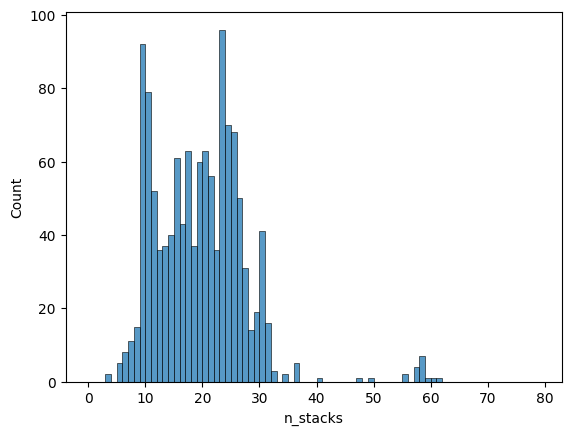

In [7]:
sns.histplot(
    data=df.to_pandas(),
    x="n_stacks",
    bins=np.arange(0, 80, 1)
);

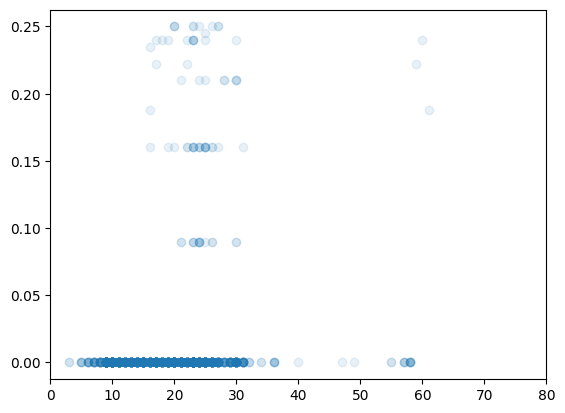

In [17]:
plt.scatter(
    df["n_stacks"],
    df["ImprovementVariance"],
    alpha=0.1
);
plt.xlim([0, 80]);
#plt.xscale("log")

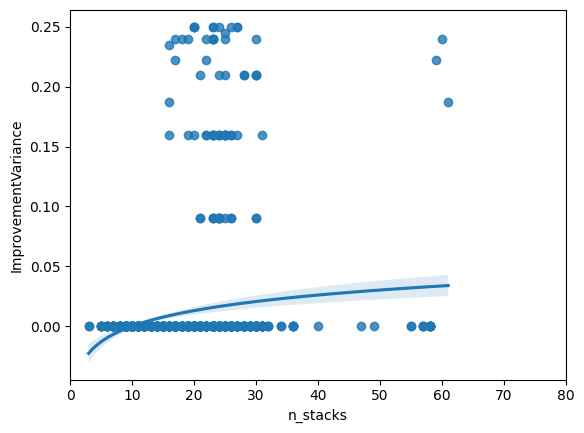

In [13]:
sns.regplot(
    data=df.to_pandas(),
    x="n_stacks",
    y="ImprovementVariance",
    #logistic=True,
    logx=True,
    #order=2
);
plt.xlim([0, 80]);

In [11]:
#df = pl.DataFrame({"raw": texts})
print(df[-6, "logs"])

Packing Index: 139
Rerun: 0
----------------------------------------------------------------------------------------------------
2D Packing MIP with Time Limit 2 [s] in Truck P252646403
Stack 0 with items: ['0091017300_03072022000913', '0091017300_03072022013799', '0091017300_03072022013799']
Stack 1 with items: ['0091017300_03072022012218', '0091017300_03072022012218', '0091017300_03072022012218', '0091017300_03072022012218']
Stack 2 with items: ['0091017300_03072022000913', '0091017300_03072022000913', '0091017300_03072022000913']
Stack 3 with items: ['0091017300_03072022012218', '0091017300_03072022012218', '0091017300_03072022012218', '0091017300_03072022012218']
Stack 4 with items: ['0091017300_03072022012218', '0091017300_03072022012218', '0091017300_03072022012218', '0091017300_03072022012218']
Stack 5 with items: ['0091017300_03072022012218', '0091017300_03072022012218', '0091017300_03072022013799']
Stack 6 with items: ['0091017300_03072022010624', '0091017300_03072022012218', 

In [36]:
print(df[510, "logs"])

Packing Index: 16
Rerun: 0
----------------------------------------------------------------------------------------------------
2D Packing MIP with Time Limit 2 [s] in Truck P231305201
Stack 0 with items: ['0090018400_03072022000935']
Stack 1 with items: ['0090018400_03072022000935']
Stack 2 with items: ['0090018400_03072022000935']
Stack 3 with items: ['0090018400_03072022000935']
Stack 4 with items: ['0090018400_03072022000934', '0090018400_03072022000934']
Stack 5 with items: ['0090018400_03072022000934']
Stack 6 with items: ['0090018400_03072022000896']
Stack 7 with items: ['0090018400_03072022000896']
Stack 8 with items: ['0090018400_03072022000896']
Stack 9 with items: ['0090018400_03072022000896']
Stack 10 with items: ['0090018400_03072022000779']
Stack 11 with items: ['0090018400_03072022000779']
Stack 12 with items: ['0090018400_03072022000779']
Stack 13 with items: ['0090018400_03072022000779']
Stack 14 with items: ['0090018400_03072022000779']
Stack 15 with items: ['00900184